In [1]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram
from cmath import cos, sin, pi
import math
from math import sqrt
import mne
from mne import io

In [3]:
# Plot and save the PSD of the signal
# f, PSD_eeg = PSD_cp(eeg_filtered,fs,False,target_frequencies,chan_name)
def PSD_cp(eeg_data,fs,plot,target_frequencies,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Compute the PSD of the filtered signal
    f, Pxx_den = signal.welch(eeg_data, fs, nperseg=4*fs)
    
    if (plot == True):
        # Plot the PSD for each channel of the filtered signal
        fig, axs = plt.subplots(2, 4, figsize=(15, 10))
        fig.suptitle('PSD of the signal')
        for i in range(len(eeg_data)):
            axs[i//4, i%4].semilogy(f[0:201], Pxx_den[i][0:201])
            axs[i//4, i%4].set_xlabel('Frequency (Hz)')
            axs[i//4, i%4].set_ylabel('PSD [V**2/Hz]')
            axs[i//4, i%4].set_title(chan_name[i])
            #Add some visible lines at the target frequencies 
            # for j in range(len(target_frequencies)):
            #     axs[i//4, i%4].axvline(x=target_frequencies[j], color='r', linestyle='--')
            plt.subplots_adjust(hspace=0.5, wspace=0.5)
        plt.show()
    return f, Pxx_den

In [4]:
# Plot and save the Spectrogram of the signal 
#freqs, t, Sxx = spectrogram_cp(eeg_filtered,fs,f_range,False,chan_name)
def spectrogram_cp(eeg_data,fs,f_range,plot,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Define parameters for spectrogram
    nperseg = 4*fs  # Number of samples per segment
    noverlap = 2*fs  # Number of samples overlapping between segments

    # Define empty arrays to store the spectrogram for each channel
    freqs = []
    t = []
    Sxx = []
    
    # Loop through each channel
    for channel_index in range(len(eeg_data)):
        # Calculate the spectrogram for current channel and store the results in the arrays
        freqs_current, t_current, Sxx_current = spectrogram(eeg_data[channel_index], fs, nperseg=nperseg, noverlap=noverlap)
        # Select the frequency range of interest
        freq_idx = (freqs_current >= f_range[0]) & (freqs_current <= f_range[1])
        freqs_current = freqs_current[freq_idx]
        Sxx_current = Sxx_current[freq_idx, :]
        # Append the results to the arrays
        freqs.append(freqs_current)
        t.append(t_current)
        Sxx.append(Sxx_current)
     
        
    if (plot == True): 
        # Plot the spectrogram in a 2x4 grid 
        fig, axs = plt.subplots(2, 4, figsize=(15, 10))
        fig.suptitle('Spectrogram of the signal')
        for i in range(0,8):
            im = axs[i//4, i%4].pcolormesh(t[i], freqs[i], 10 * np.log10(Sxx[i]), cmap='jet')
            fig.colorbar(im, ax=axs[i//4, i%4], label='dB/Hz')
            axs[i//4, i%4].set_xlabel('Time (s)')
            axs[i//4, i%4].set_ylabel('Frequency (Hz)')
            axs[i//4, i%4].set_title('Spectrogram for Channel ' + chan_name[i])
        fig.subplots_adjust(wspace=0.5, hspace=0.5, bottom=0.15)
        plt.show()   
        
    # Convert the arrays to numpy arrays
    freqs = np.array(freqs)
    t = np.array(t)
    Sxx = np.array(Sxx)
    return freqs, t, Sxx

In [5]:
def freq_snr(Pxx_den, f, frequency_interest, frequencies_interest):
    # Find the index of the frequency of interest
    idx_interest = np.argmin(np.abs(f - frequency_interest))
    # Find the indices of the frequencies of interest
    idx_interests = []
    for freq in frequencies_interest:
        idx_interests.append(np.argmin(np.abs(f - freq)))
    # Calculate the power at the frequency of interest
    power_interest = Pxx_den[:, idx_interest]
    # Calculate the total power at the frequencies of interest
    total_power_interests = np.sum(Pxx_den[:, idx_interests], axis=1)
    # Calculate the ratio of power at frequency of interest to the total power at frequencies of interest
    ratio = power_interest / total_power_interests
    return ratio

In [6]:
# Paper rls filter function
def rls_filter(y, f,lambda_, fs, delta):
    # Recursive Least Squares (RLS) filter from the paper : https://pubmed.ncbi.nlm.nih.gov/7750452/
    # An adaptive filter for steady-state evoked responses.
    
    # y is the input signal -> EEG signal in our case. But in the paper y is interpreted as the desired signal.
    # x is the frequency of interest.
    # P is the number of filter coefficients -> our case fixed at 2. In terms of RLS filter, 
    # the number of coefficients is actually 1 since we only work with most recent sample
    P = 2
    # lambda_ is the forgetting factor. Usually between 0.9 and 0.999
    # delta is the initial value of the inverse correlation matrix. Usually some small value like 0.001
    
    # Initialize the filter coefficients. P is fixed at 2 in our case.
    w_all = np.zeros([P, len(y)])
    
    #Initialize the desired signal. This the paper interprets as the input signal.
    x1 = np.zeros([len(y),1]) 
    x2 = np.zeros([len(y),1])
    x = np.zeros([2,len(y)])
    # Make x1 a sine of the desired frequency f
    x1 = np.sin(2*np.pi*f*np.arange(0,len(y),1)/fs)
    # Make x2 a cosine of the desired frequency f
    x2 = np.cos(2*np.pi*f*np.arange(0,len(y),1)/fs)
    # Stack x1 and x2 to make x
    x = np.vstack((x1,x2)) 
    
    # Initialize the inverse correlation matrix as a numpy array
    R = delta*np.eye(P) 
    
    # Initialize the output signal
    y_hat = np.zeros([len(y),1])
    
    # Initialize the error signal
    e = np.zeros([len(y),1])
    
    # Loop through the samples one by one
    for i in range(0,len(y)):
        
        # 1. Compute the adaptation gain
        k_num = (1/lambda_)*(R@x[:,i])  
        k_den = 1 + (1/lambda_)*(x[:,i].T@R@x[:,i])
        k  = k_num/k_den
        k = np.reshape(k, (P,1))

        # 2. Error signal & update signal estimate
        y_hat[i] = (w_all[:,i-1].T)@x[:,i]
        e[i] = y[i] - y_hat[i] 
        
        # 3. Update the filter coefficients
        w_all[:,i] = w_all[:,i-1] + k@e[i]
    
        # 4. Update the inverse correlation matrix
        x_temp = np.reshape(x[:,i], (2,1))
        R = (1/lambda_) * R - (1/lambda_)* k@x_temp.T@R     
        
    return y_hat,w_all

In [7]:
# new_array = correct_size(array)
def correct_size(arr):
    # Check if the input is a valid NumPy array
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    # Get the length of the array
    number = arr.shape[1]

    # Find the logarithm base 2 of the number
    log2_number = math.log2(number)

    # Calculate the lower and upper powers of two
    lower_power_of_two = 2 ** math.floor(log2_number)
    upper_power_of_two = 2 ** math.ceil(log2_number)

    # Calculate the distances to the lower and upper powers of two
    distance_lower = abs(number - lower_power_of_two)
    distance_upper = abs(number - upper_power_of_two)

    # Return the closest power of two, whether it is higher or lower than the length of the array
    if distance_lower <= distance_upper:
        #return a temporary array which has the values of arr but removed enough so its closest power of 2
        return arr[:,0:lower_power_of_two]
    else:
        #return a temporary array which has the values of arr but zero padded enough so its closest power of 2
        return np.pad(arr, ((0,0),(0,upper_power_of_two-number)), 'constant', constant_values=(0))


In [8]:
def resample(f_original,f_desired,data):
    # Find the coprime numbers between the original and desired frequencies
    coprime_number = np.gcd(f_original,f_desired)
    P = int(f_desired / coprime_number) # Upsampling factor
    Q = int(f_original / coprime_number) # Downsampling factor
    
    # Create a temporary array to store the resampled data
    data_temp = []
    
    # Add P-1 zeros between each sample
    for i in range(0,data.shape[0]):
        data_temp.append(data[i])
        for j in range(0,P-1):
            data_temp.append(0)
    data_temp = np.array(data_temp)

    cut_off = int((P*f_original)/max(2*P,2*Q))-1 # Cut-off frequency for anti-aliasing filter
    
    # Low pass filter the data with a cut-off frequency of cut_off
    b, a = signal.butter(5, cut_off, 'low', analog=False, fs=P*f_original)
    
    # Apply the filter to the data_temp array
    data_temp = signal.filtfilt(b, a, data_temp, axis=0)
    
    # Keep every Qth sample
    data_temp = data_temp[::Q]
    
    return data_temp

In [9]:
# Introduce information about the channels
chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']
left_channels = ['PO3', 'PO7', 'O1']
center_channels = ['POz', 'Oz']
right_channels = ['PO4', 'PO8', 'O2']
zone_names = ['Left', 'Center', 'Right']

# Convert the channels to the corresponding index from chan_name
left_channels_index = [chan_name.index(i) for i in left_channels]
center_channels_index = [chan_name.index(i) for i in center_channels]
right_channels_index = [chan_name.index(i) for i in right_channels]
# Target frequency
target_frequency = 17
target_frequencies = [14,15,16,17,18,19,20]

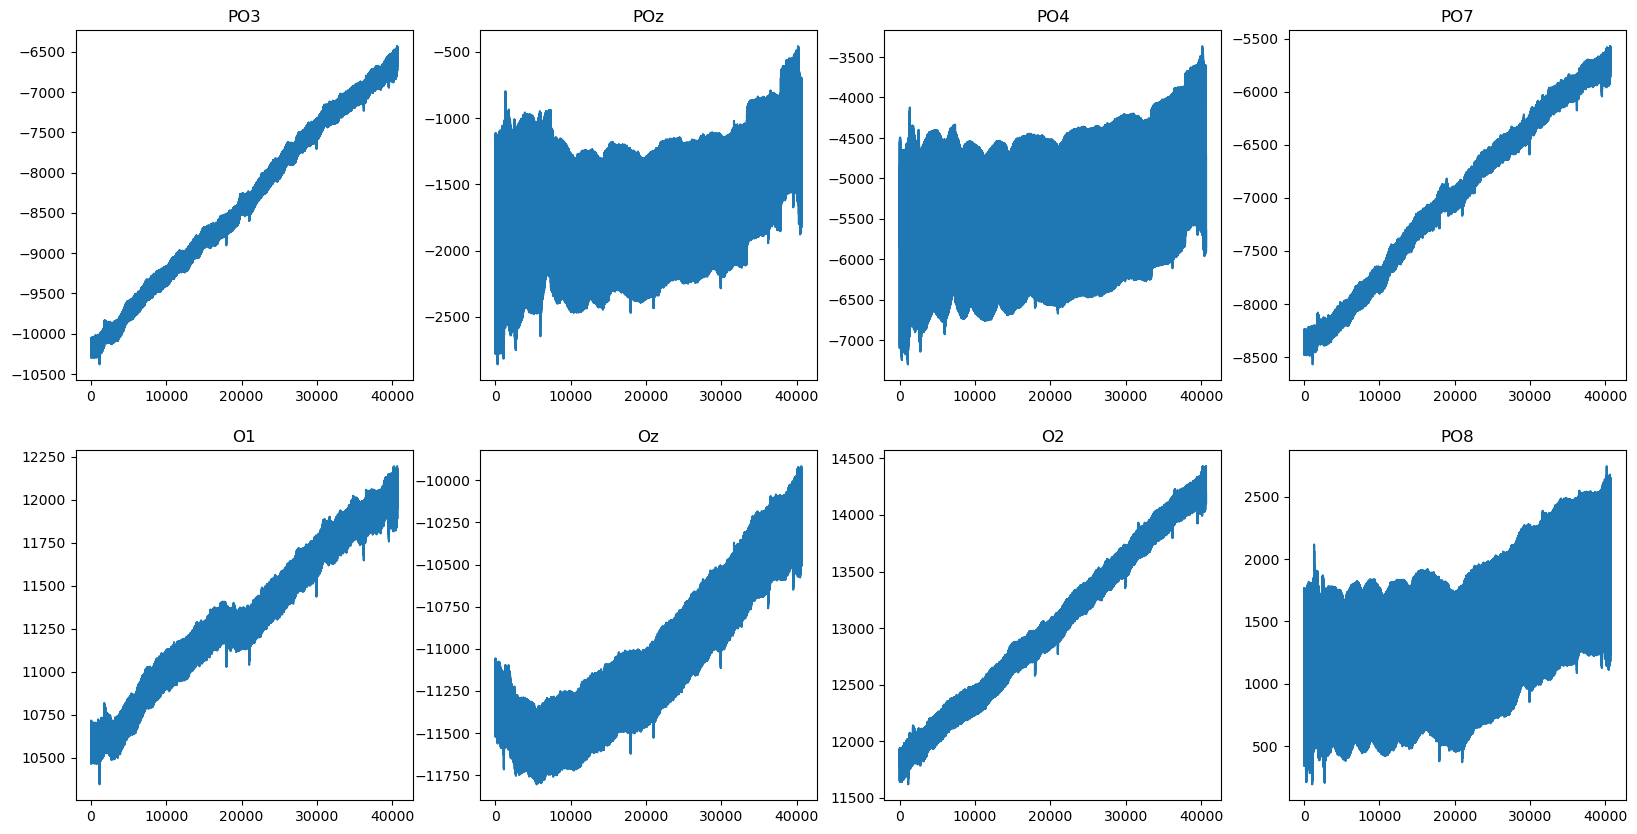

In [10]:
fs = 250 # Sampling frequency
# Load the raw EEG data
eeg_data = pd.read_csv("data/Liuyin-5April/Morning/wet_17hz_0504_clean_ExG.csv")

# Remove the first column which contains the time stamps
eeg_data = eeg_data.iloc[:,1:]

# Convert the data to a numpy array
eeg_data = eeg_data.to_numpy()
eeg_data = eeg_data.T
# Plot the raw EEG data channel by channel in a 2 x 4 grid 
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(0,8):
    axs[i//4,i%4].plot(eeg_data[i,:])
    axs[i//4,i%4].set_title(chan_name[i])
    

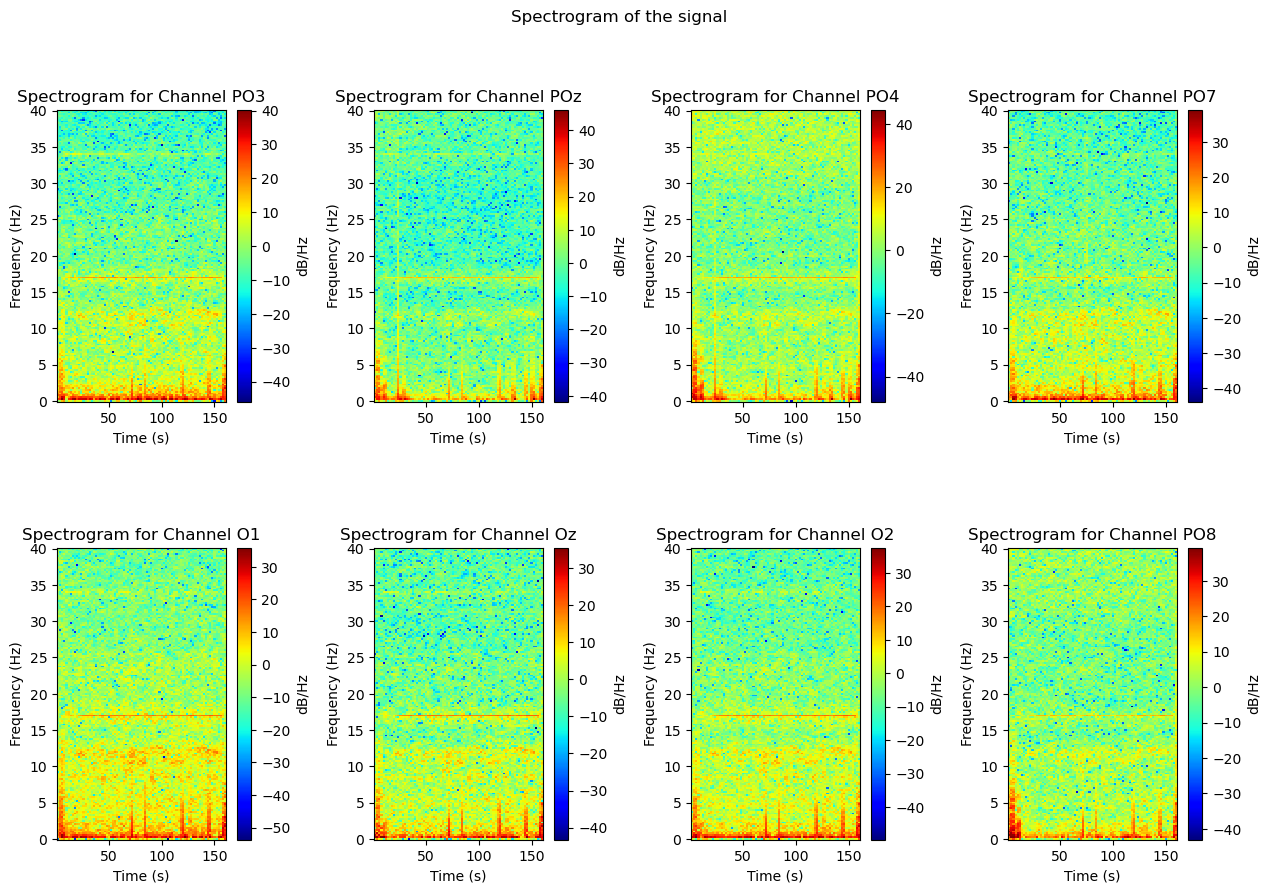

In [11]:
# Plot the spectrogram of the EEG data using spectrogram_cp function
f_range = [0,40]
f, t__,Spect_eeg = spectrogram_cp(eeg_data,fs,f_range,True,chan_name)

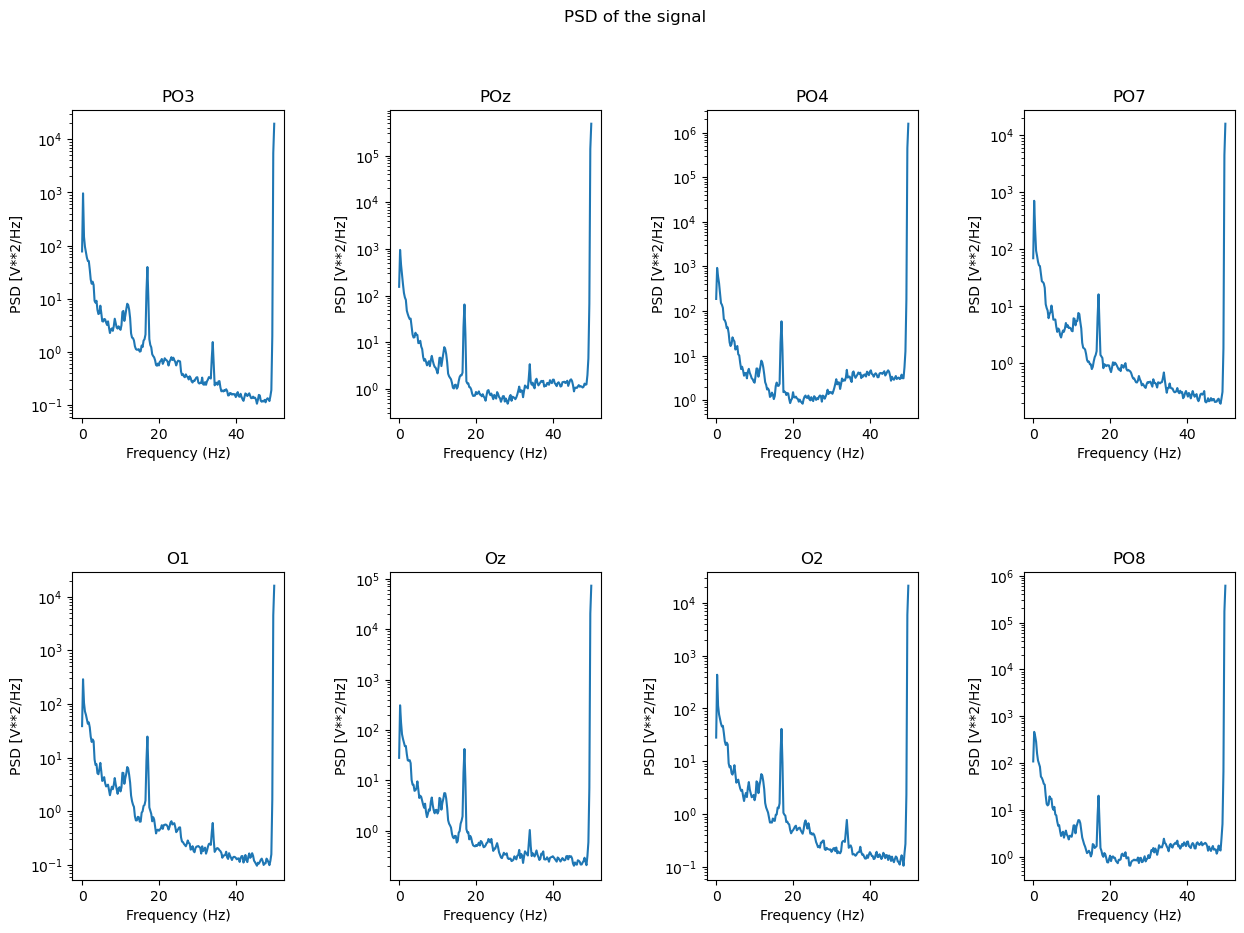

In [12]:
# Plot the PSD of the EEG data using PSD_cp function 
f, PSD_eeg = PSD_cp(eeg_data,fs,True,target_frequencies,chan_name)

In [13]:
frequency_interest = 17
frequencies_interest = [14,15,16,17,18,19,20]
ratio = freq_snr(PSD_eeg, f, frequency_interest, frequencies_interest)
# Print the SNR ratio for each channel also using the name of the channel
for i in range(0,8):
    print(chan_name[i], ratio[i])

PO3 0.8638359407411608
POz 0.9019575358027088
PO4 0.8742098110048302
PO7 0.7198319854966456
O1 0.8479424659663277
Oz 0.8979472208809987
O2 0.8943780546415129
PO8 0.7461884495562138


In [14]:
## This part is for the RLS filter from the paper.
# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 17 Hz
y_hat = []
# Initialize a list to store the RLS filter coefficients
filter_coefficients = []

for i in range(len(eeg_data)):
    # Apply the RLS filter to the EEG signal
    sig, coeff = rls_filter(eeg_data[i],7.5,0.95,fs,1e-4)
    # Append the filtered signal to the list y_hat
    y_hat.append(sig)
    # Append the filter coefficients to the list filter_coefficients
    filter_coefficients.append(coeff)

# Transpose all elements in the list y_hat so that they are in the same format as the EEG signal
for i in range(len(y_hat)):
    y_hat[i] = y_hat[i].T

# Rearrange y_hat so it has same dimensions as eeg_array 
y_hat = np.array(y_hat)
y_hat = np.reshape(y_hat, (eeg_data.shape[0], eeg_data.shape[1]))


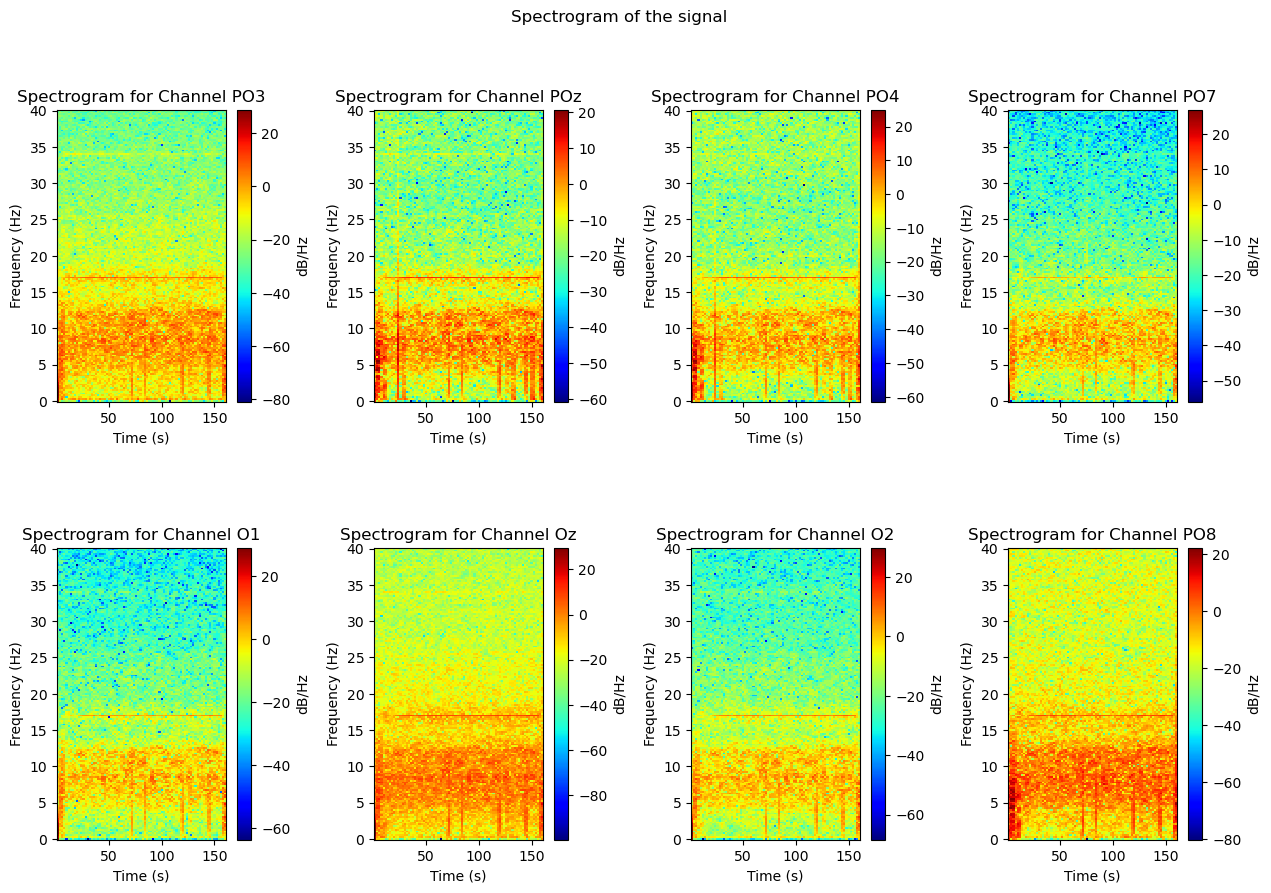

In [15]:
# Plot the spectrogram of the filtered EEG signal using spectrogram_cp function
f, t__,Spect_eeg = spectrogram_cp(y_hat,fs,f_range,True,chan_name)

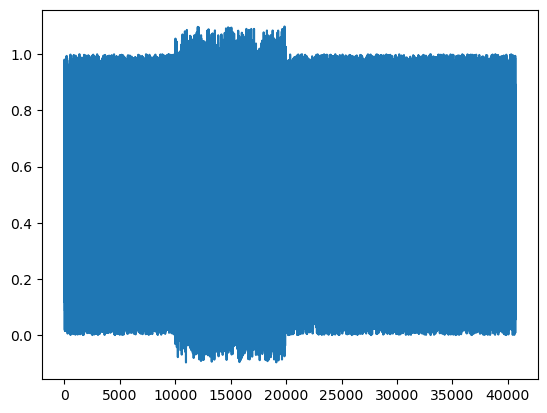

In [16]:
# Generate a random signal. This is the signal that will be used to test the RLS filter. 
x = np.random.rand(1,eeg_data.shape[1])

# Slightly amplify the 17 Hz component of the signal in the second 10000 samples 
x[0,10000:20000] = x[0,10000:20000] + 0.1*np.sin(2*np.pi*17*np.arange(10000)/fs)
#Transpose the signal
x = x.T

# Plot the signal
plt.figure()
plt.plot(x[:,0])
plt.show()

# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 17 Hz
y_hat = []
# Initialize a list to store the RLS filter coefficients
filter_coefficients = []

y_hat,filter_coefficients = rls_filter(x,17,0.95,fs,1e-4)


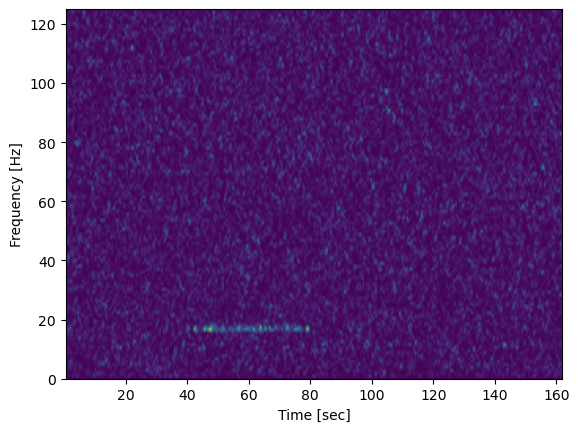

In [17]:
#plot the spectrogram of the signal x usings signal.spectrogram
f, t, Sxx = signal.spectrogram(x[:,0], fs, nperseg=256, noverlap=128, nfft=256, scaling='spectrum')
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


(2, 40672)


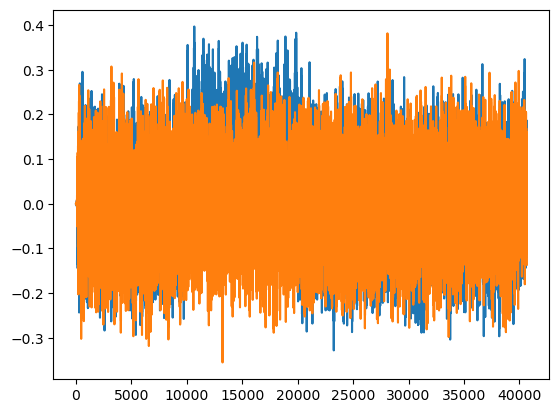

In [18]:
print(filter_coefficients.shape)
plt.figure()
plt.plot(filter_coefficients[0,:])
plt.plot(filter_coefficients[1,:])
plt.show()


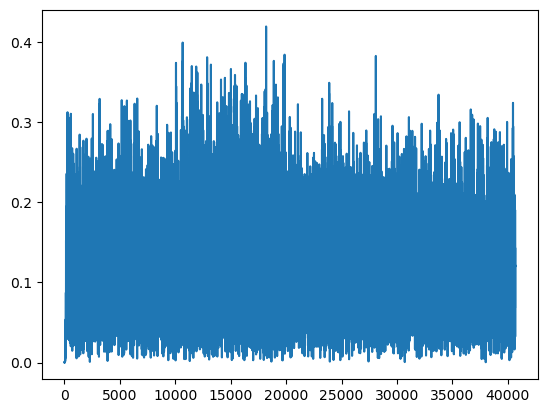

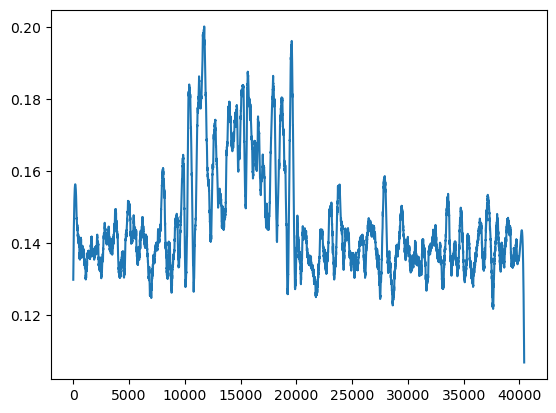

In [19]:
# Calculate the amplitude of the filter coefficients
amp_test = []
for i in range(len(filter_coefficients[0])):
    amp_test.append(np.sqrt(filter_coefficients[0,i]**2 + filter_coefficients[1,i]**2))
    
plt.figure()
plt.plot(amp_test)
plt.show()

# Smooth the amplitude of the filter coefficients
amp_test = np.array(amp_test)
amp_test_smooth = signal.savgol_filter(amp_test, 1000, 5)
# Plot the smoothed amplitude of the filter coefficients
plt.figure()
plt.plot(amp_test_smooth[250:])
plt.show()



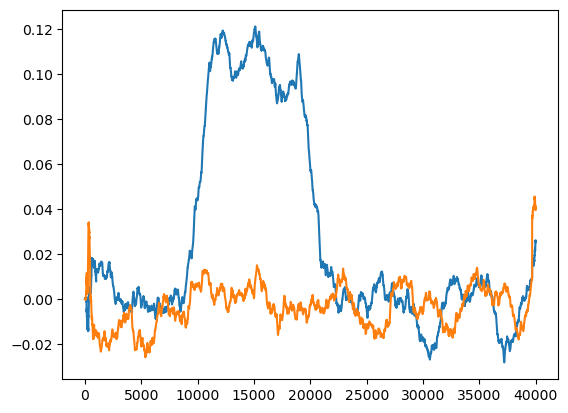

In [20]:
# loop over the list w_5
fixed_moving_avg_1 = []
fixed_moving_avg_2 = []
for i in range(len(filter_coefficients[0])):
    # Calculate the moving average over +- 1000 samples. If the index is too close to the start or end of the signal, the moving average is calculated over the available samples
    if i < 1000:
        fixed_moving_avg_1.append(sum(filter_coefficients[0,:i])/(i+1))
        fixed_moving_avg_2.append(sum(filter_coefficients[1,:i])/(i+1))
    elif i > len(filter_coefficients[0]) - 1000:
        fixed_moving_avg_1.append(sum(filter_coefficients[0,i:])/(len(filter_coefficients[0])-i))
        fixed_moving_avg_2.append(sum(filter_coefficients[1,i:])/(len(filter_coefficients[0])-i))
    else:
        fixed_moving_avg_1.append(sum(filter_coefficients[0,i-1000:i+1000])/(2000))
        fixed_moving_avg_2.append(sum(filter_coefficients[1,i-1000:i+1000])/(2000))
# Plot the coherent average
plt.figure()
plt.plot(fixed_moving_avg_1[:40000])
plt.plot(fixed_moving_avg_2[:40000])
plt.show()


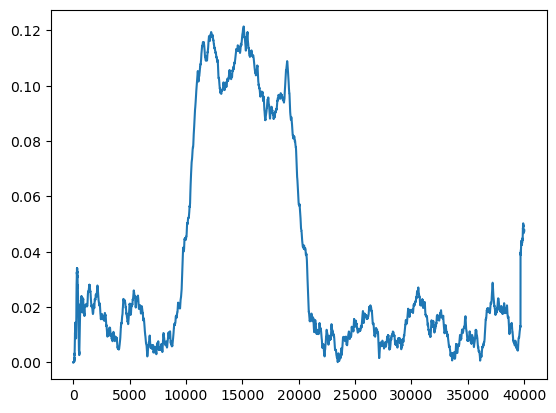

In [21]:
amp_improved_test = []
for i in range(len(filter_coefficients[0])):
    amp_improved_test.append(np.sqrt(fixed_moving_avg_1[i]**2 + fixed_moving_avg_2[i]**2))
    
plt.figure()
plt.plot(amp_improved_test[:40000])
plt.show()

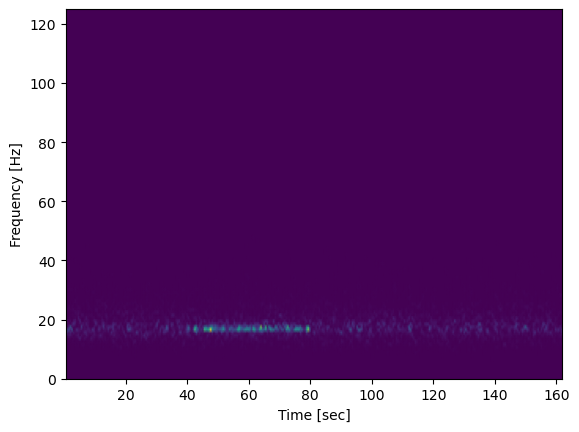

In [22]:
# Plot the spectogram of the signal x not using the spectogram_cp function
f, t, Sxx = signal.spectrogram(y_hat[:,0], fs, nperseg=256, noverlap=128, scaling='spectrum')
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 930399  =      0.000 ...   930.399 secs...
Event file found. Extracting Annotations from /Users/barci/BCI/data/Liuyin-19April/1804_SSVEP_VR_1.ceo...
Shape of EEG data array: (8, 930400)


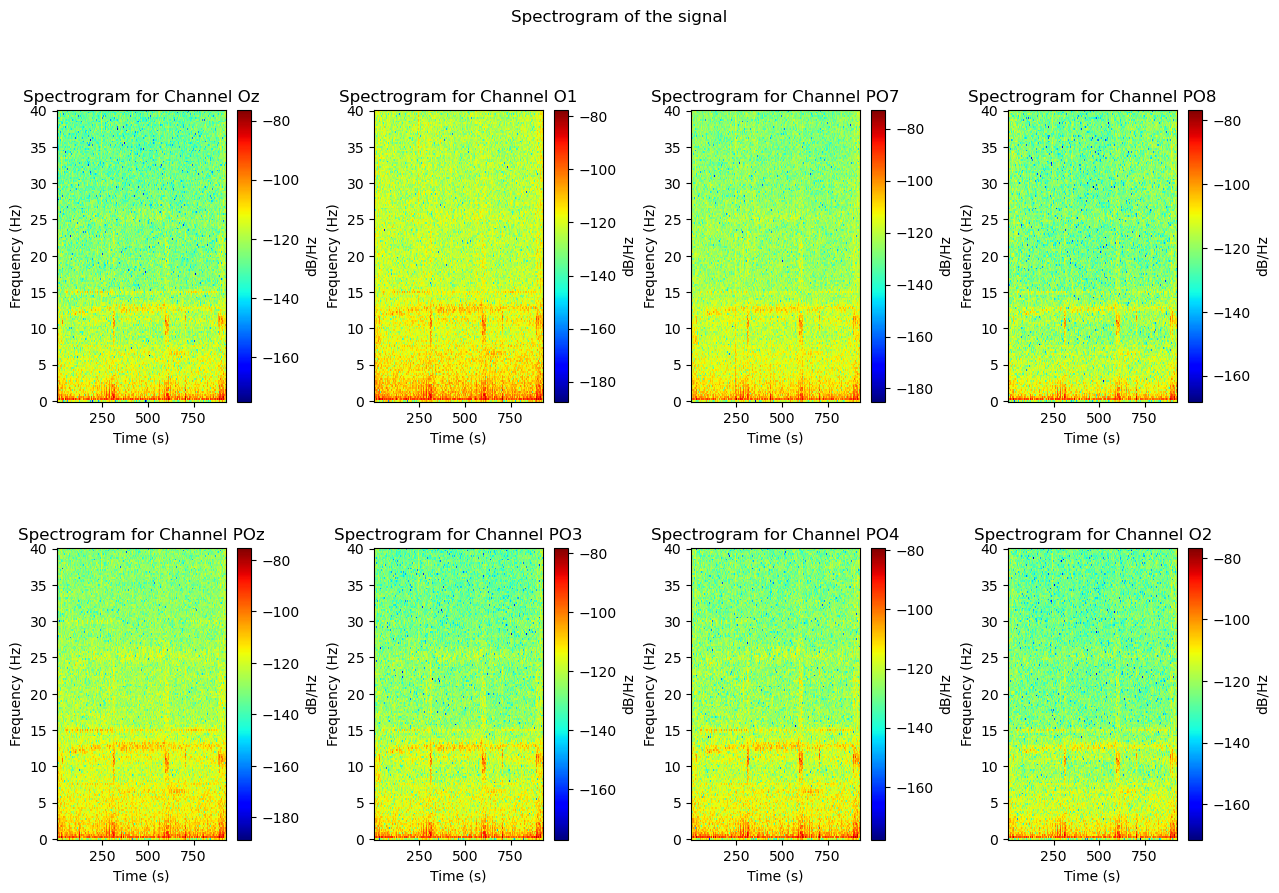

In [31]:
# Curry file analysis
# Set the path to the .dat file
path_to_dat_file = 'data/Liuyin-19April/1804_SSVEP_VR_1.dat'

# Read the EEG data using the read_raw_curry function
raw = mne.io.read_raw_curry(path_to_dat_file, preload=True)

# Make a copy of the raw object
raw_copy = raw.copy()

# In the raw copy object, pick the channels that you want to use for the analysis which are defined in chan_name
raw_copy.pick_channels(chan_name)

# Get the EEG data from the raw copy object
c_data = raw_copy.get_data()

# Get channel names for the EEG data
chan_names = raw_copy.ch_names

# Print the shape of the EEG data array
print('Shape of EEG data array:', c_data.shape)

# Get the sampling frequency
fs = int(raw.info['sfreq'])


# Plot the spectrogram of the EEG signal using the spectrogram_cp function
f, t, Sxx = spectrogram_cp(c_data,fs,f_range,True,chan_names)

# Get markers from the raw_copy object
markers = raw_copy.annotations

# Get the onset of the markers
onset = markers.onset

# Get the duration of the markers
duration = markers.duration

# Get the description of the markers
description = markers.description

description_int = []
for i in range(len(description)):
    description_int.append(int(description[i]))

#Define a list of start or stop
start_stop = []
# Divide each description_int by 100. If rounded result is 1 add Start to start_stop list. If rounded result is 2 add Stop to start_stop list
for i in range(len(description_int)):
    if round(description_int[i]/100) == 1:
        start_stop.append(0) # 0 = start
    elif round(description_int[i]/100) == 2:
        start_stop.append(1) # 1 = stop
    else:
        start_stop.append(3) # 3 = None
        
# Define a list of experiment index
exp_index = []

# Divide each description_int by 100 and get the remainder. Then divide the remainder by 10. If rounded result is 0 add experiment0 to exp_index list. If rounded result is 1 add experiment to exp_index list
for i in range(len(description_int)):
    if round((description_int[i]%100)/10) == 0:
        exp_index.append(0)
    elif round((description_int[i]%100)/10) == 1:
        exp_index.append(1)
    elif round((description_int[i]%100)/10) == 2:
        exp_index.append(2)
    elif round((description_int[i]%100)/10) == 3:
        exp_index.append(3)
    else:
        exp_index.append(100)

# Define a list of trial index
trial_index = []
# Divide each description_int by 100 and get the remainder. Then divide the remainder by 10 and get remainder. If rounded result is 0 add trial0 to trial_index list. If rounded result is 1 add trial1 to trial_index list
for i in range(len(description_int)):
    if round((description_int[i]%100)%10) == 0:
        trial_index.append(0)
    elif round((description_int[i]%100)%10) == 1:
        trial_index.append(1)
    elif round((description_int[i]%100)%10) == 2:
        trial_index.append(2)
    elif round((description_int[i]%100)%10) == 3:
        trial_index.append(3)
    else:
        trial_index.append(100)

# Define a list of epochs
epochs = []

# Fill the epochs list with EEG samples between the start and stop markers
for i in range(len(start_stop)):
    if start_stop[i] == 0:
        if i < len(start_stop)-1:
            epochs.append(c_data[:,int(onset[i]*fs):int((onset[i+1]*fs))])
            
        else:
            epochs.append(c_data[:,int(onset[i]*fs):])
            



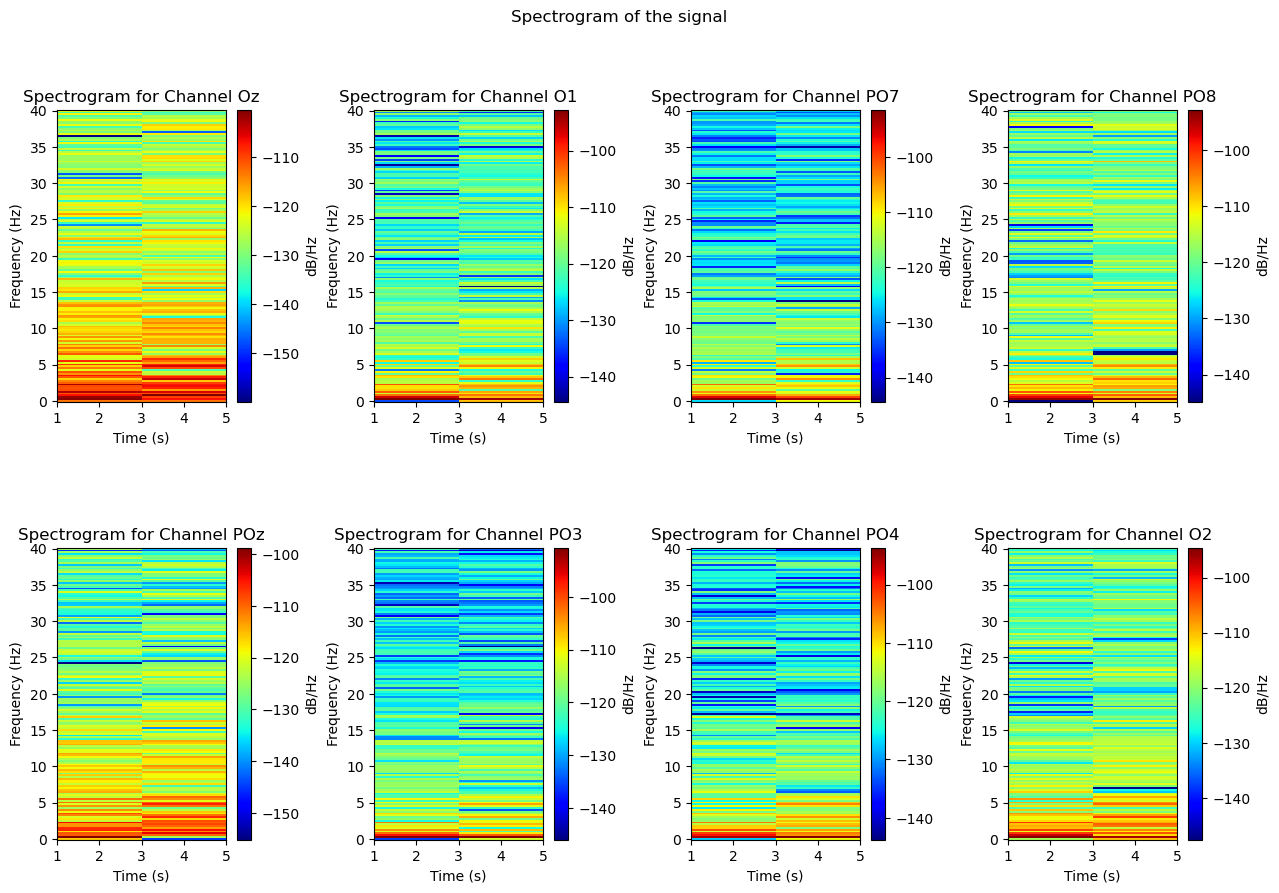

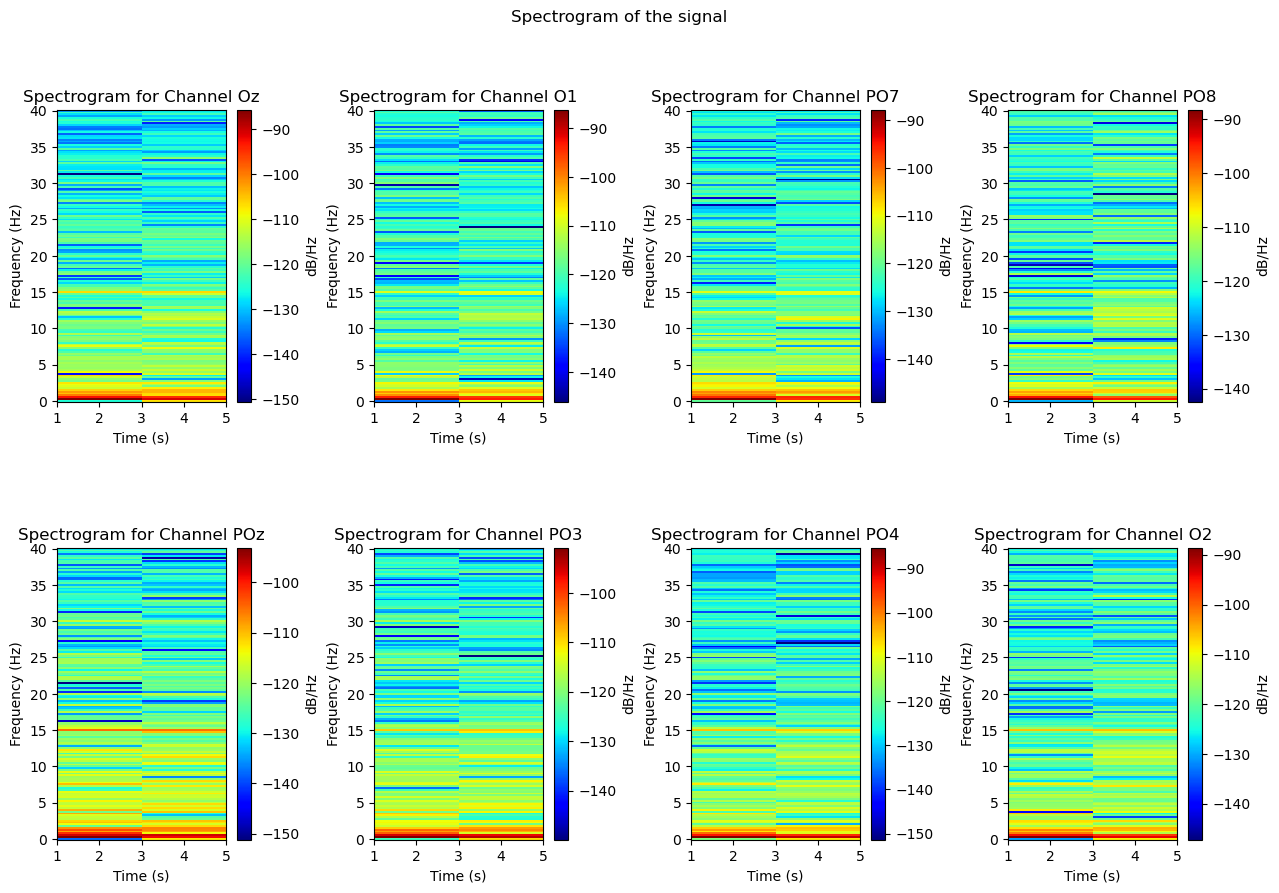

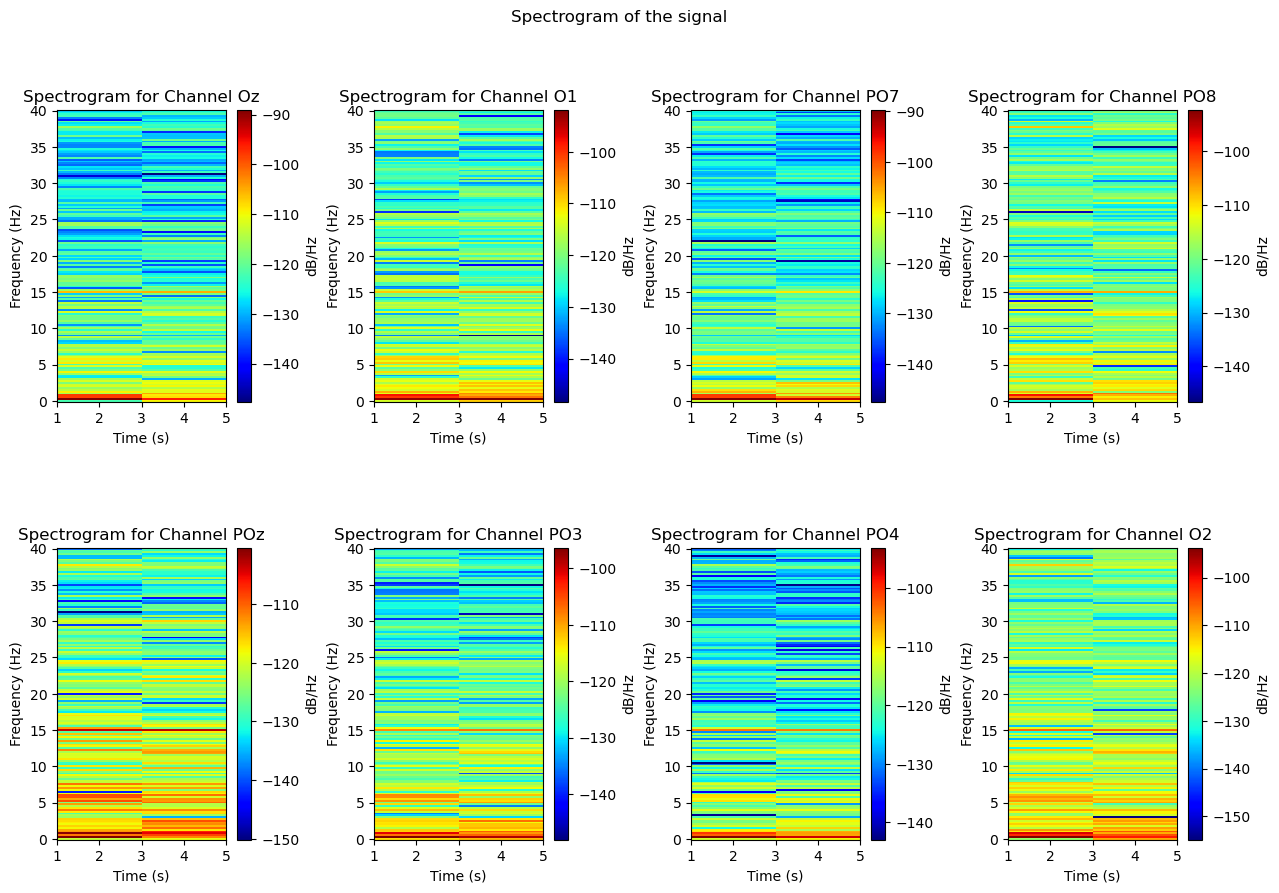

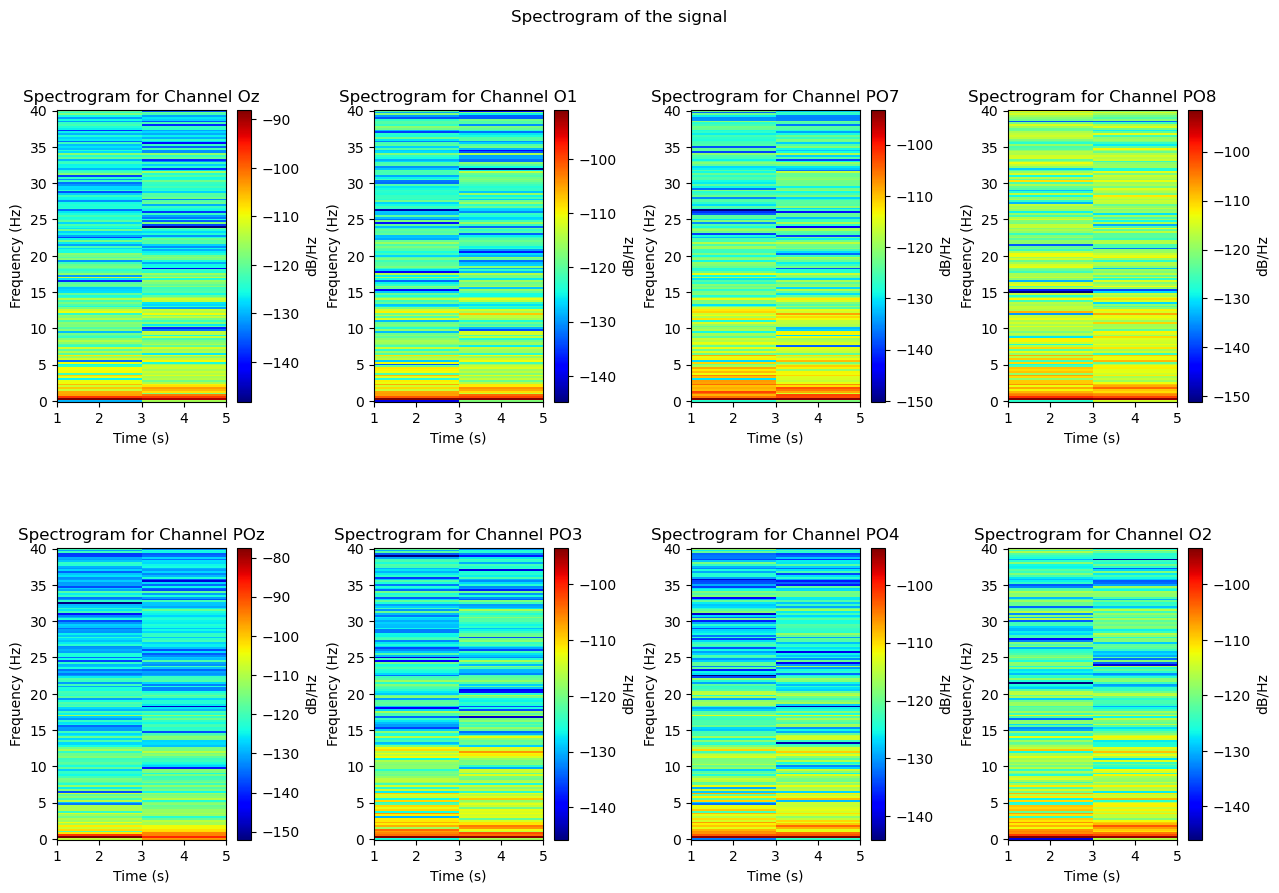

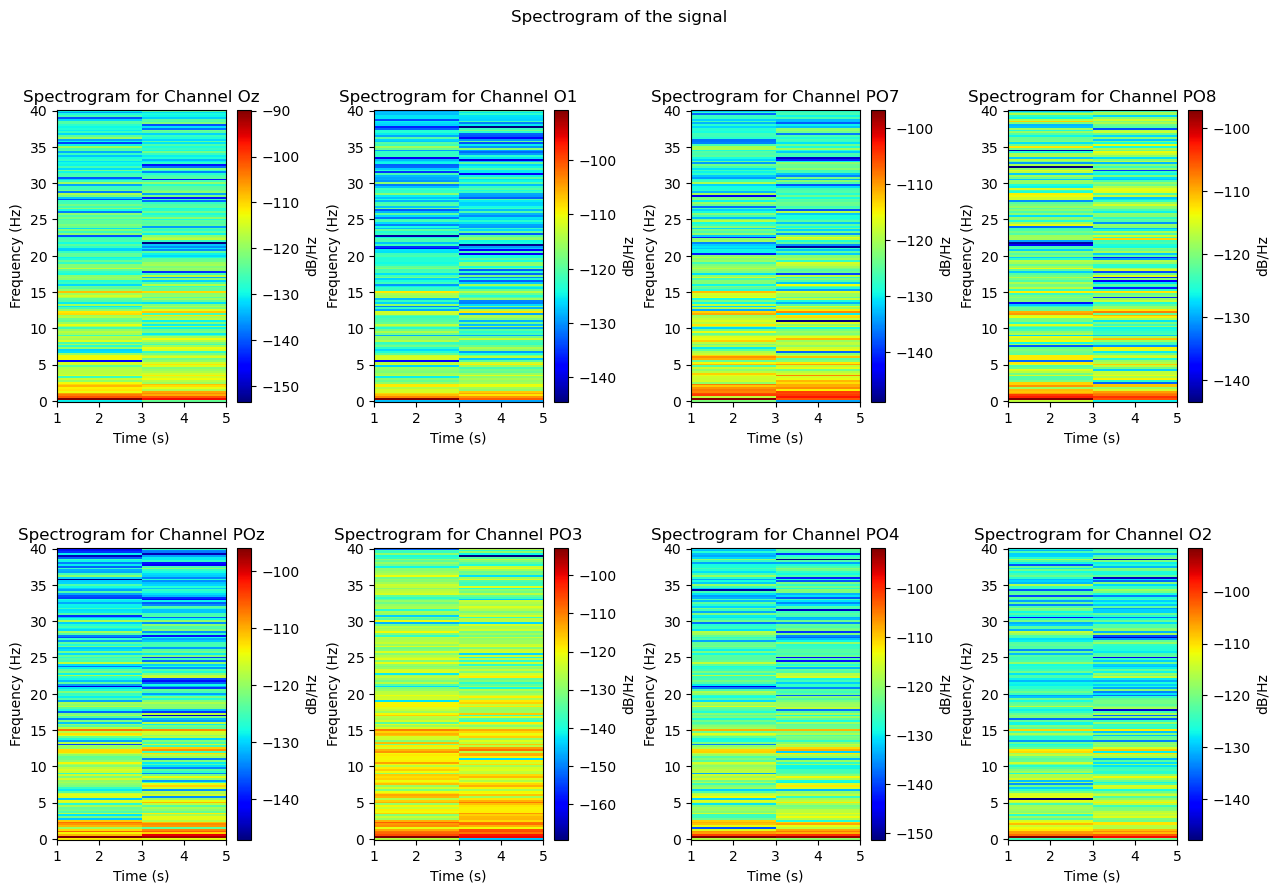

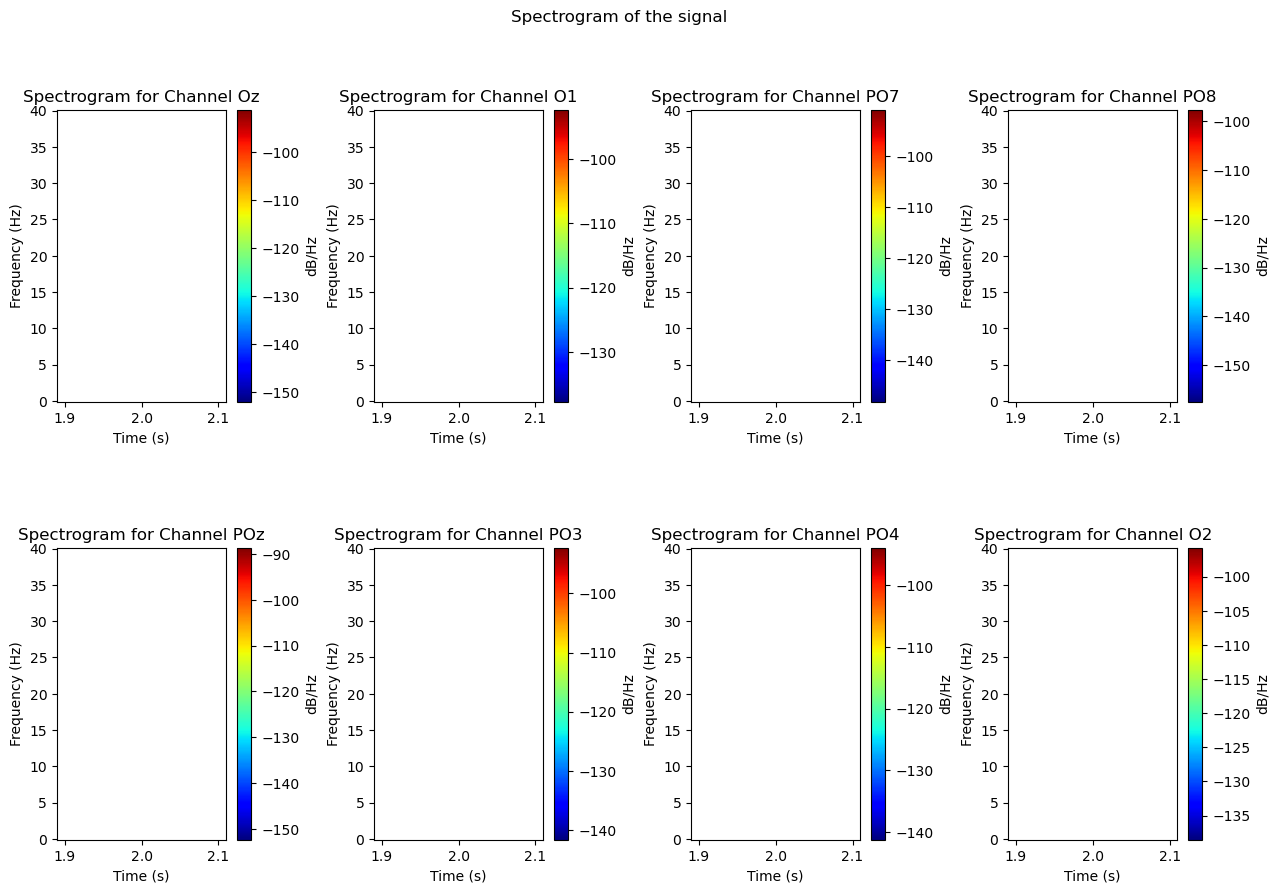

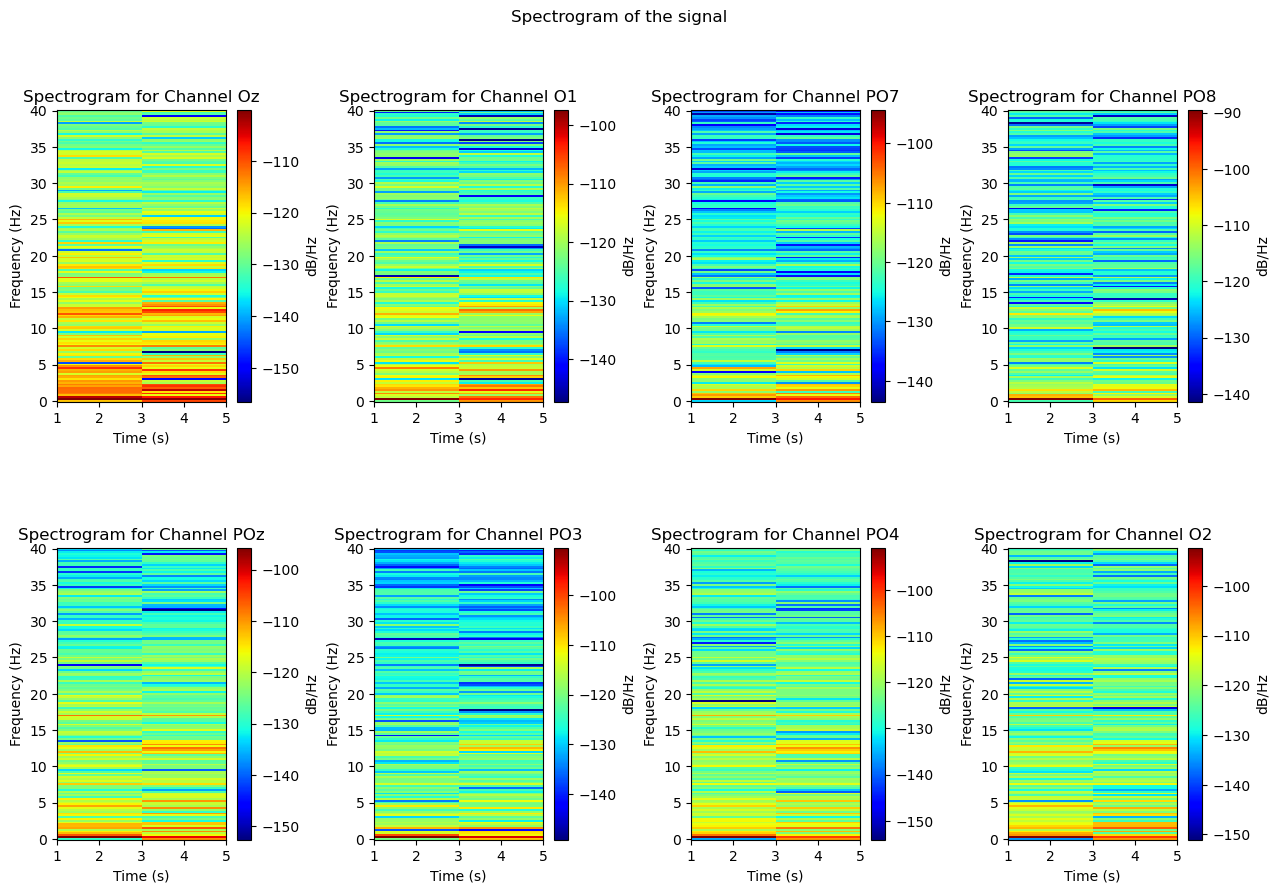

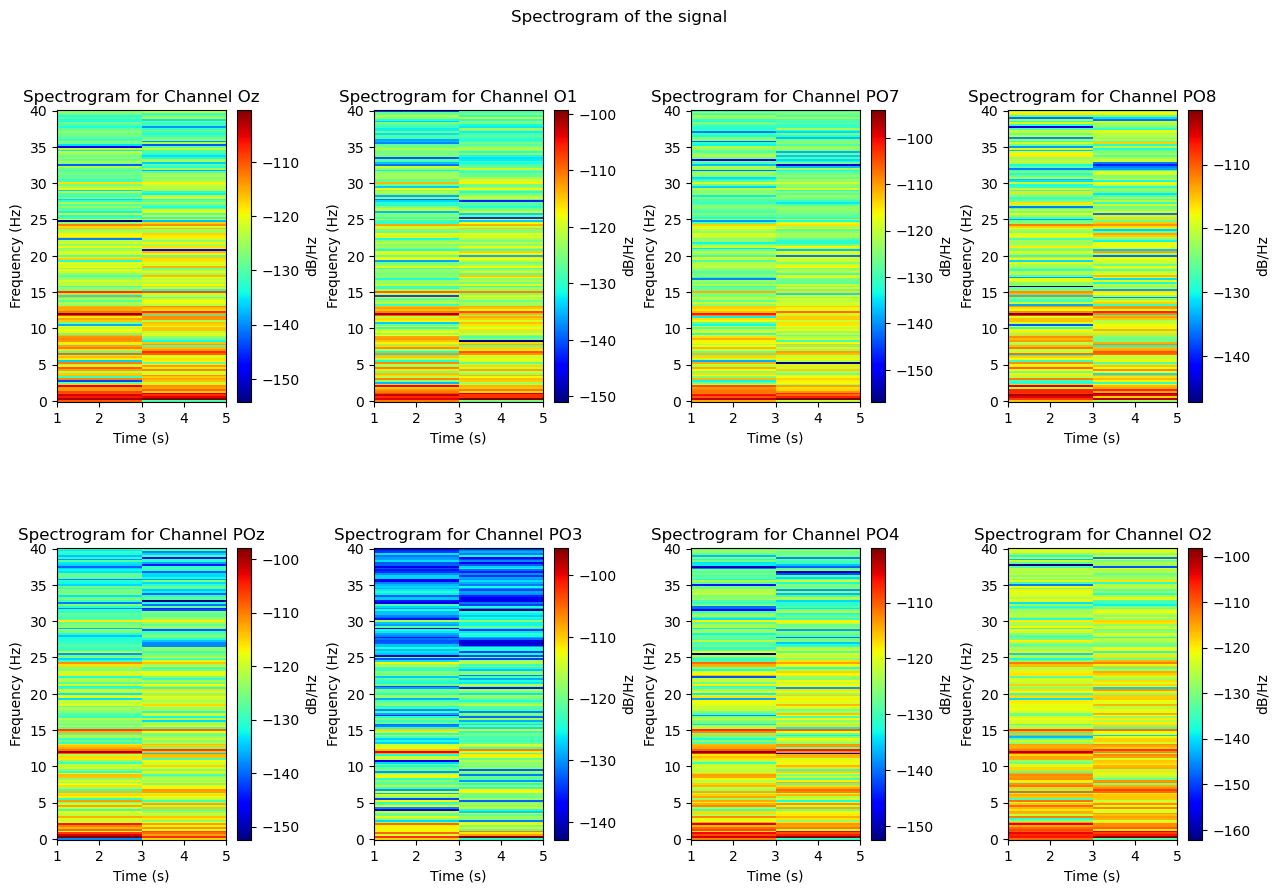

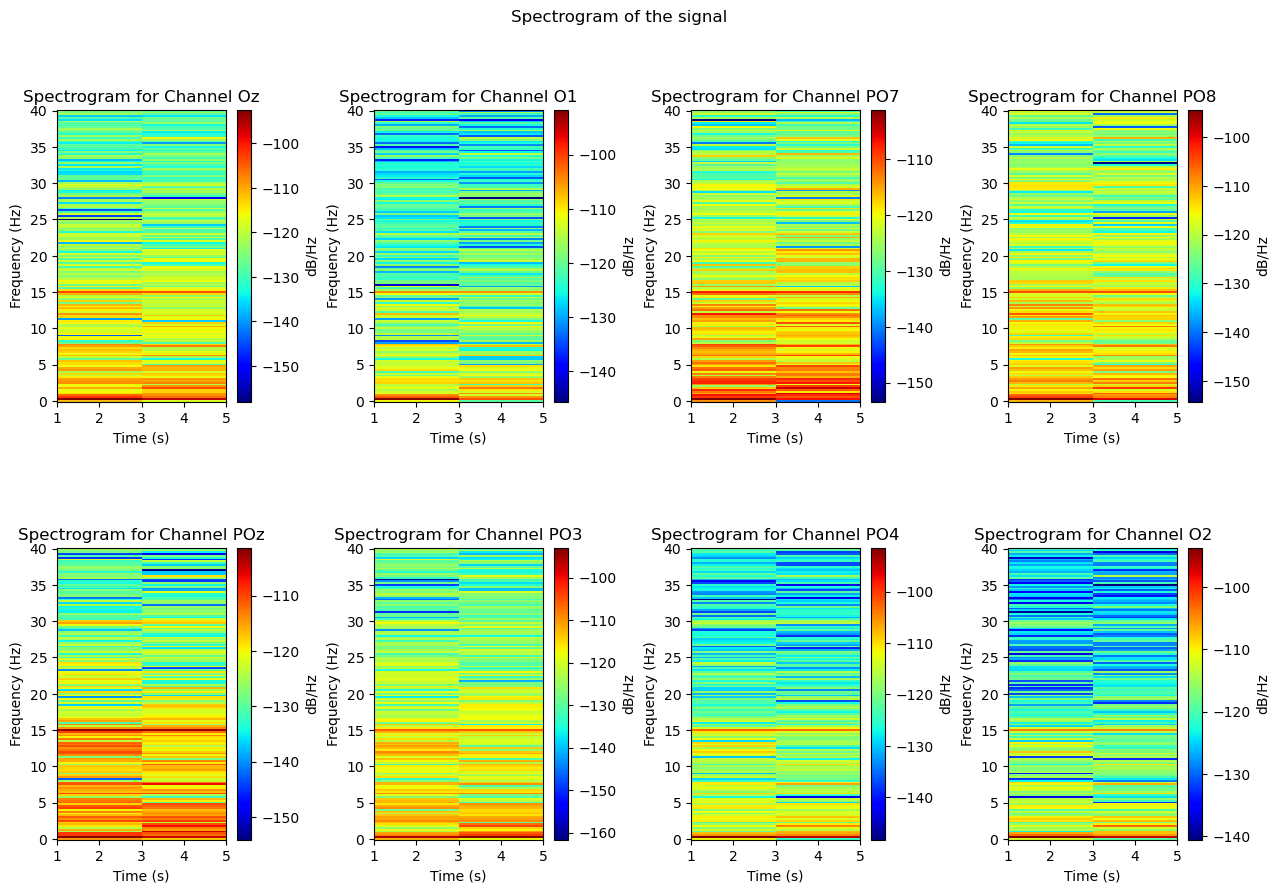

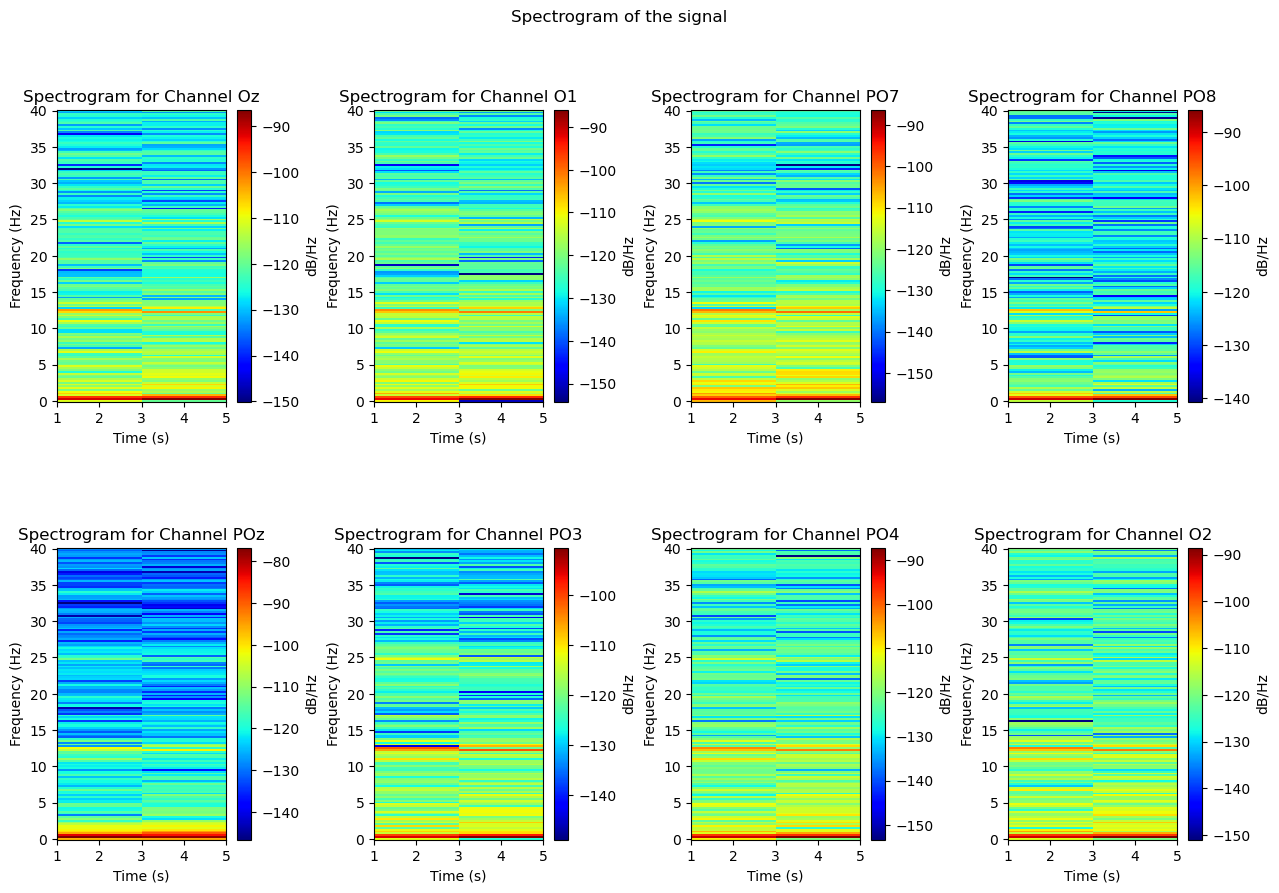

In [33]:
# Plot spectrogram of first 10 epochs
for i in range(10):
    f, t, Sxx = spectrogram_cp(epochs[i],fs,f_range,True,chan_names)